# Combining galaxy models in Kepler orbits:

### Given the semimajor axis and perigalactic distance of two galaxies in a typical two-body problem, along with the eccentric anomaly of each galaxy in its orbit, we can create an initial condition that will place them in a Keplerian orbit around the center of mass of the system.

### Imports:

In [4]:
import pynbody
import pynbody.plot.sph as sph
import matplotlib.pylab as plt
import numpy as np
from scipy.integrate import solve_ivp
import astropy.units as u
import astropy.constants as const
import astropy.units

## Class for generating initial conditions and testing that the galaxies are in fact in a Kepler orbits:

In [21]:
class Bodys:
    """
    Create an initial condition for two galaxies in a kepler orbit.
    Attributes:
    Gal1, PyNBody TipsySnap 
    Gal2, PyNbody TipsySnap
    d_perigalactic1 = perigalactic distance given in kpc
    semimajor_axis1 = semimajor axis given in kpc
    E1 = eccentric anomaly of galaxy 1 in radians. 
    E2 = eccentric anomaly of galaxy 2 in radians. Equal E is out of phase by pi, therefore E1 and E2 both being zero places them at opposite sides of their orbits.
    writename = output file name (string)
    """

    def __init__(self, Gal1, Gal2, d_perigalactic, semimajor_axis, E1, E2, writename):
        self.Gal1 = Gal1
        self.Gal2 = Gal2       
        self.d_perigalactic = d_perigalactic * u.kpc
        self.semimajor_axis = semimajor_axis * u.kpc
        self.E1 = E1
        self.E2 = E2
        self.writename = writename
        
        self.G = const.G
        self.Mass1 = float(self.Gal1['mass'].sum().in_units('kg'))*u.kg
        self.Mass2 = float(self.Gal2['mass'].sum().in_units('kg'))*u.kg
        self.MassTot = self.Mass1 + self.Mass2
        
              
    def get_vxvy(self, which_gal):
        """Finds the velocity componants in cartesian that, given the parameters passed into the class, would result
        in a Keplerian two-body orbit."""
        print(self.MassTot)

        #k = np.sqrt(self.G*(self.Mass1 + self.MassTot))
        k = np.sqrt(self.G*self.MassTot)
        a = self.semimajor_axis
        rp = self.d_perigalactic
        e = 1 - (rp/a)     
        b = a * np.sqrt(1-e**2)
        n = k * a**(-3/2)

        # Gal1 ###############################################################
        E1 = self.E1

        # Find positions
        X1 = a * (np.cos(E1) - e)
        Y1 = b * np.sin(E1)

        # Find velocity componants
        vX1 = (-a * n * np.sin(E1)) / (1 - e * np.cos(E1)) 
        vY1 = (b * n * np.cos(E1)) / (1 - e * np.cos(E1))
        
        # Transition from position in orbital plane to position in space
        # [x;y;z] = P[X;Y;Z] 
        # P = I in this case as all Euler angles are 0
        # r and r dot... go to rho
        q1 = -1
        x1 = q1*X1
        y1 = q1*Y1
        vx1 = q1*vX1
        vy1 = q1*vY1         
        
        # Gal2 ###############################################################
        E2 = self.E2

        # Find positions
        # e sign
        X2 = a * (np.cos(E2) - e)
        Y2 = b * np.sin(E2)

        # Find velocity componants
        vX2 = (-a * n * np.sin(E2)) / (1 - e * np.cos(E2)) 
        vY2 = (b * n * np.cos(E2)) / (1 - e * np.cos(E2))
        
        # Transition from position in orbital plane to position in space
        # [x;y;z] = P[X;Y;Z] 
        # P = -I in this case as the Omega Euler angle is pi
        q2 = 1

        x2 = q2*X2
        y2 = q2*Y2
        vx2 = q2*vX2
        vy2 = q2*vY2

        # COM ################################################################  
        
        self.xcom = (x1*self.Mass1 + x2*self.Mass2)/self.MassTot
        self.ycom = (y1*self.Mass1 + y2*self.Mass2)/self.MassTot
        print('xcom = ' + str(self.xcom))
         
        if which_gal == Gal1: 
            return x1, y1, vx1, vy1
        elif which_gal == Gal2:
            return x2, y2, vx2, vy2
        
    def get_period(self):
        """Returns the period of orbit in seconds based on Kepler's laws."""
        k = np.sqrt(self.G*self.MassTot)
        T = np.sqrt(((4*np.pi**2) / (k**2)) *self.semimajor_axis**3)
        print('T:' + str(T.decompose()))
        return T
    
    def initial_conds(self, which_gal):
        """Returns the initial positions and velocities for galaxy given by which_gal. Utility function."""     
        x, y, vx, vy = self.get_vxvy(which_gal)
        print(str(which_gal) + ': x,y,vx,vy = ' + str((x,y,vx.decompose(),vy.decompose())))
        return x, y, vx, vy

    def equations(self, t, p):
        """Splits second order diff eqquations of motion into four first order differential equations."""
        
        r = np.sqrt((p[0])**2 + (p[1])**2)
        
        #         u1 = x
        #         u2 = y
        #         u3 = dx
        #         u4 = dy

        du1 = p[2]
        du2 = p[3]
        du3 = -(((self.G * self.MassTot).value) / r**3) * (p[0]) 
        du4 = -(((self.G * self.MassTot).value) / r**3) * (p[1])
        return [du1, du2, du3, du4]
    
    def solve_ivp(self, which_gal):
        """Test IC by solving eq for galaxies as if they were point sources."""
        nsteps = 10000
        period = self.get_period().to(u.s).value
        t_eval = np.linspace(0, period, nsteps)
        

        if which_gal == Gal1:
            x1, y1, vx1, vy1 = self.initial_conds(Gal1)
            sol = solve_ivp(self.equations, [0, period], [x1.to(u.m).value, y1.to(u.m).value, vx1.to(u.m/u.s).value, vy1.to(u.m/u.s).value],
                            t_eval = t_eval, rtol=1e-6)
        elif which_gal == Gal2:
            x2, y2, vx2, vy2 = self.initial_conds(Gal2)
            sol = solve_ivp(self.equations, [0, period], [x2.to(u.m).value, y2.to(u.m).value, vx2.to(u.m/u.s).value, vy2.to(u.m/u.s).value],
                            t_eval = t_eval, rtol=1e-6)
        return sol
    
    def combine(self):
        """Combines the two galaxies into a new TipsySnap. Massunit = 2.2222858e5 Msol. Length unit = 1 kpc."""
        #these x y z refer to initial condit to be added
        x1, y1, vx1, vy1 = self.initial_conds(which_gal = self.Gal1)
        x2, y2, vx2, vy2 = self.initial_conds(which_gal = self.Gal2)
        
        x1 = ((x1).to(u.kpc)).value * (self.Mass1 / self.MassTot)
        y1 = ((y1).to(u.kpc)).value * (self.Mass1 / self.MassTot)
        x2 = ((x2).to(u.kpc)).value * (self.Mass2 / self.MassTot)
        y2 = ((y2).to(u.kpc)).value * (self.Mass2 / self.MassTot)
        
        vx1 = ((vx1).to(.9778 * u.km/u.s)).value * (self.Mass1 / self.MassTot)
        vy1 = ((vy1).to(.9778 * u.km/u.s)).value * (self.Mass1 / self.MassTot)
        vx2 = ((vx2).to(.9778 * u.km/u.s)).value * (self.Mass2 / self.MassTot)
        vy2 = ((vy2).to(.9778 * u.km/u.s)).value * (self.Mass2 / self.MassTot)
        
        lengths = {}
        for fam in Gal1.families():
            lengths[fam.name] = len(Gal1[fam])

        gal1_shifted = pynbody.new(**lengths)

        Omega1 = 0
        w1 = 0
        i1 = np.pi/4
        P1 = np.matrix([[np.cos(Omega1)*np.cos(w1)-np.sin(Omega1)*np.cos(i1)*np.sin(w1), -np.cos(Omega1)*np.sin(w1)-np.sin(Omega1)*np.cos(i1)*np.cos(w1), np.sin(Omega1)*np.sin(i1)],
               [np.sin(Omega1)*np.cos(w1)+np.cos(Omega1)*np.cos(i1)*np.sin(w1), -np.sin(Omega1)*np.sin(w1)+np.cos(Omega1)*np.cos(i1)*np.cos(w1), -np.cos(Omega1)*np.sin(i1)],
               [np.sin(i1)*np.sin(w1), np.sin(i1)*np.cos(w1), np.cos(i1)]])       
        
        print("Tranforming Gal1")    
        for fam in Gal1.families():
            s1 = Gal1[fam]
    
            pos1 = []
            vel1 = []
            print(fam)
            for i in range(len((s1)['pos'])):
                X1, Y1, Z1 = s1['pos'].in_units('kpc')[i][0], s1['pos'].in_units('kpc')[i][1], s1['pos'].in_units('kpc')[i][2]
                vX1, vY1, vZ1 = s1['vel'].in_units('.9778 km s**-1')[i][0], s1['vel'].in_units('.9778 km s**-1')[i][1], s1['vel'].in_units('.9778 km s**-1')[i][2]
                p1 = np.matrix([[X1],[Y1],[Z1]])
                v1 = np.matrix([[vX1],[vY1],[vZ1]])

                M1 = (P1*p1)
                vM1 = (P1*v1)
                
                new_x1 = M1[0,0]
                new_y1 = M1[1,0]
                new_z1 = M1[2,0]
                
                new_vx1 = vM1[0,0]
                new_vy1 = vM1[1,0]
                new_vz1 = vM1[2,0]
                
                s1['pos'][i] = [new_x1,new_y1,new_z1]
                s1['vel'][i] = [new_vx1,new_vy1,new_vz1]
            
            gal1_shifted[fam][:len(s1)]['pos'] = s1['pos'].in_units('kpc') + [x1, y1, 0]
            gal1_shifted[fam][:len(s1)]['vel'] = s1['vel'].in_units('.9778 km s**-1') + [vx1, vy1, 0]
            gal1_shifted[fam][:len(s1)]['mass'] = s1['mass'].in_units('2.2222858e5 Msol')
            gal1_shifted[fam][:len(s1)]['rho'] = s1['rho'].in_units('2.2222858e5 Msol kpc**-3')
            gal1_shifted[fam][:len(s1)]['eps'] = s1['eps']

        gal1_shifted.write(filename='temp1.tipsy', fmt=pynbody.tipsy.TipsySnap, cosmological = False)        
        
        lengths = {}
        for fam in Gal2.families():
            lengths[fam.name] = len(Gal2[fam])

        gal2_shifted = pynbody.new(**lengths)

        Omega1 = 0
        w1 = 0
        i1 = 0
        P2 = np.matrix([[np.cos(Omega1)*np.cos(w1)-np.sin(Omega1)*np.cos(i1)*np.sin(w1), -np.cos(Omega1)*np.sin(w1)-np.sin(Omega1)*np.cos(i1)*np.cos(w1), np.sin(Omega1)*np.sin(i1)],
               [np.sin(Omega1)*np.cos(w1)+np.cos(Omega1)*np.cos(i1)*np.sin(w1), -np.sin(Omega1)*np.sin(w1)+np.cos(Omega1)*np.cos(i1)*np.cos(w1), -np.cos(Omega1)*np.sin(i1)],
               [np.sin(i1)*np.sin(w1), np.sin(i1)*np.cos(w1), np.cos(i1)]])        
              
        print("Tranforming Gal2")    
        for fam in Gal2.families():
            s1 = Gal2[fam]
            
            pos1 = []
            vel1 = []
            print(fam)
            for i in range(len((s1)['pos'])):
                X1, Y1, Z1 = s1['pos'].in_units('kpc')[i][0], s1['pos'].in_units('kpc')[i][1], s1['pos'].in_units('kpc')[i][2]
                vX1, vY1, vZ1 = s1['vel'].in_units('.9778 km s**-1')[i][0], s1['vel'].in_units('.9778 km s**-1')[i][1], s1['vel'].in_units('.9778 km s**-1')[i][2]
                p1 = np.matrix([[X1],[Y1],[Z1]])
                v1 = np.matrix([[vX1],[vY1],[vZ1]])

                M1 = (P2*p1)
                vM1 = (P2*v1)
                
                new_x1 = M1[0,0]
                new_y1 = M1[1,0]
                new_z1 = M1[2,0]
                
                new_vx1 = vM1[0,0]
                new_vy1 = vM1[1,0]
                new_vz1 = vM1[2,0]
                
                s1['pos'][i] = [new_x1,new_y1,new_z1]
                s1['vel'][i] = [new_vx1,new_vy1,new_vz1]
            
            gal2_shifted[fam][:len(s1)]['pos'] = s1['pos'].in_units('kpc') + [x2, y2, 0]
            gal2_shifted[fam][:len(s1)]['vel'] = s1['vel'].in_units('.9778 km s**-1') + [vx2, vy2, 0]
            gal2_shifted[fam][:len(s1)]['mass'] = s1['mass'].in_units('2.2222858e5 Msol')
            gal2_shifted[fam][:len(s1)]['rho'] = s1['rho'].in_units('2.2222858e5 Msol kpc**-3')
            gal2_shifted[fam][:len(s1)]['eps'] = s1['eps']

        gal2_shifted.write(filename='temp2.tipsy', fmt=pynbody.tipsy.TipsySnap, cosmological = False)

        # combining
        for fam in gal1_shifted.families():
            lengths[fam.name] = len(gal1_shifted[fam])+len(gal2_shifted[fam])

        combined = pynbody.new(**lengths)

        for fam in Gal1.families():
            s1 = gal1_shifted[fam]
            s2 = gal2_shifted[fam]
            for arname in 'pos','vel','mass', 'rho', 'eps':
                combined[fam][:len(s1)][arname] = s1[arname]
                combined[fam][len(s1):][arname] = s2[arname]

        combined.write(filename=self.writename, fmt=pynbody.tipsy.TipsySnap, cosmological = False)
        return combined
    
    def make_param_file(self):
        """Creates a param file for use in ChaNGa. Sets nSteps to integrate over one orbital period."""
        p = self.get_period()
        
        dDelta = 0.01
            
        #check    
        gyears = p.to(1e9*u.year)
        print(gyears)
        steps = gyears / dDelta
        
        achInFile = self.writename

        # write data in a file. 
        file = open(self.writename + ".param","w") 
        L = ["nSteps = " + str(int(steps.value)) + "\n", "dTheta = 0.7 \n","dEta = .03 \n","dDelta = " + str(dDelta) + " \n","iOutInterval = 500 \n",
             "achInFile = " + achInFile + " \n","achOutName = " + self.writename +" \n", "iLogInterval = 1 \n",
             "dMsolUnit = 2.2222858e5 \n", "dKpcUnit = 1 \n", "dDumpFrameStep = 25 \n", "iDirector = 1 \n"]  

        file.writelines(L) 
        file.close() #to change file access modes 
        
    def make_director_file(self):
        """Creates a param file for use in ChaNGa. Sets nSteps to integrate over one orbital period."""
        # write data in a file. 
        file = open(self.writename + ".director","w")
        z = 0.5 * self.semimajor_axis.value + 20
        L = ["size 1000 1000 \n", "clip 0.001 500 \n","render tsc \n","target 0 0 0 \n","physical \n",
             "file " + str(self.writename) + " \n","project perspective \n", "softdark 0.2 \n",
              "logscale 100000000000 10000000000000000 \n", "colstar 1. 0.3 0. 5e-18 \n", "coldark 0.2 0.2 5 7e-16 \n",
             "dDumpFrameStep = 25 \n", "iDirector = 1 \n", "gas off \n", "FOV 90 \n", "up 0 1 0 \n", "eye 0. 0. " + str(z) + " \n"]                             
        
        file.writelines(L) 
        file.close() #to change file access modes

### Instantiating our class and plotting the initial condition with PyNBody:

In [22]:
plt.style.use('ggplot')

# Load models here
Gal1 = pynbody.load('./InitialConditions/initHQv2')
Gal2 = pynbody.load('./InitialConditions/initHQv22')

# Instantiate class
two_bodys = Bodys(Gal1, Gal2, 25, 50, np.pi, np.pi, 'HQincreased.tipsy')
two_bodys.make_param_file()
two_bodys.make_director_file()
combined = two_bodys.combine()

T:5.456519085937362e+18 s
172.9066559541081 1e+09 yr
7.295991249876128e+37 kg
xcom = 0.0 kpc
<SimSnap "./InitialConditions/initHQv2" len=100000>: x,y,vx,vy = (<Quantity 75. kpc>, <Quantity -5.30287619e-15 kpc>, <Quantity 1.45045524e-13 m / s>, <Quantity 1025.70887178 m / s>)
7.295991249876128e+37 kg
xcom = 0.0 kpc
<SimSnap "./InitialConditions/initHQv22" len=100000>: x,y,vx,vy = (<Quantity -75. kpc>, <Quantity 5.30287619e-15 kpc>, <Quantity -1.45045524e-13 m / s>, <Quantity -1025.70887178 m / s>)
Tranforming Gal1
dm


/home/michael/miniconda3/lib/python3.7/site-packages/pynbody/snapshot/tipsy.py:437: RuntimeWarning: Time is unknown: writing zero in header
  "Time is unknown: writing zero in header", RuntimeWarning)


Tranforming Gal2
dm


SimArray([[1.4088614e-13, 1.4088614e-13, 1.4088614e-13, ...,
           1.4088614e-13, 1.4088614e-13, 1.4088614e-13],
          [1.4088614e-13, 1.4088614e-13, 1.4088614e-13, ...,
           1.4088614e-13, 1.4088614e-13, 1.4088614e-13],
          [1.4088614e-13, 1.4088614e-13, 1.4088614e-13, ...,
           1.4088614e-13, 1.4088614e-13, 1.4088614e-13],
          ...,
          [1.4088614e-13, 1.4088614e-13, 1.4088614e-13, ...,
           1.4088614e-13, 1.4088614e-13, 1.4088614e-13],
          [1.4088614e-13, 1.4088614e-13, 1.4088614e-13, ...,
           1.4088614e-13, 1.4088614e-13, 1.4088614e-13],
          [1.4088614e-13, 1.4088614e-13, 1.4088614e-13, ...,
           1.4088614e-13, 1.4088614e-13, 1.4088614e-13]], dtype=float32, '2.22e+05 Msol kpc**-3')

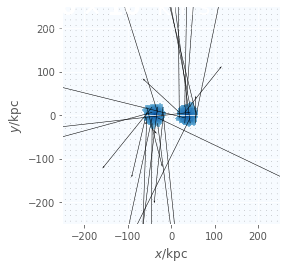

In [23]:
sph.velocity_image(combined, vector_color="black", qty="rho",width=500,cmap="Blues",
                   denoise=False,approximate_fast=False, show_cbar = False)

## Tests:

### Integrating our initial condition:

In [24]:
test1 = two_bodys.solve_ivp(Gal1)
test2 = two_bodys.solve_ivp(Gal2)

T:5.456519085937362e+18 s
7.295991249876128e+37 kg
xcom = 0.0 kpc
<SimSnap "./InitialConditions/initHQv2" len=100000>: x,y,vx,vy = (<Quantity 75. kpc>, <Quantity -5.30287619e-15 kpc>, <Quantity 1.45045524e-13 m / s>, <Quantity 1025.70887178 m / s>)
T:5.456519085937362e+18 s
7.295991249876128e+37 kg
xcom = 0.0 kpc
<SimSnap "./InitialConditions/initHQv22" len=100000>: x,y,vx,vy = (<Quantity -75. kpc>, <Quantity 5.30287619e-15 kpc>, <Quantity -1.45045524e-13 m / s>, <Quantity -1025.70887178 m / s>)


### Plotting y vs t for one (well at least its supposed to be one) period:

In [25]:
Mass1 = float(Gal1['mass'].sum().in_units('kg'))*u.kg
Mass2 = float(Gal2['mass'].sum().in_units('kg'))*u.kg
MassTot = Mass1 + Mass2


x1 = (test1['y'][0]*u.m).to(u.kpc).value * Mass1/MassTot
x2 = (test2['y'][0]*u.m).to(u.kpc).value * Mass2/MassTot
y1 = (test1['y'][1]*u.m).to(u.kpc).value * Mass1/MassTot
y2 = (test2['y'][1]*u.m).to(u.kpc).value * Mass2/MassTot

Text(0.5, 0, 't')

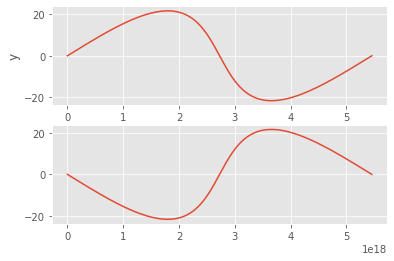

In [26]:
fig, ax = plt.subplots(2)
ax[0].plot(test1['t'],y1)
ax[1].plot(test2['t'],y2)
ax[0].set_ylabel('y')
ax[0].set_xlabel('t')

### Plotting x vs y:

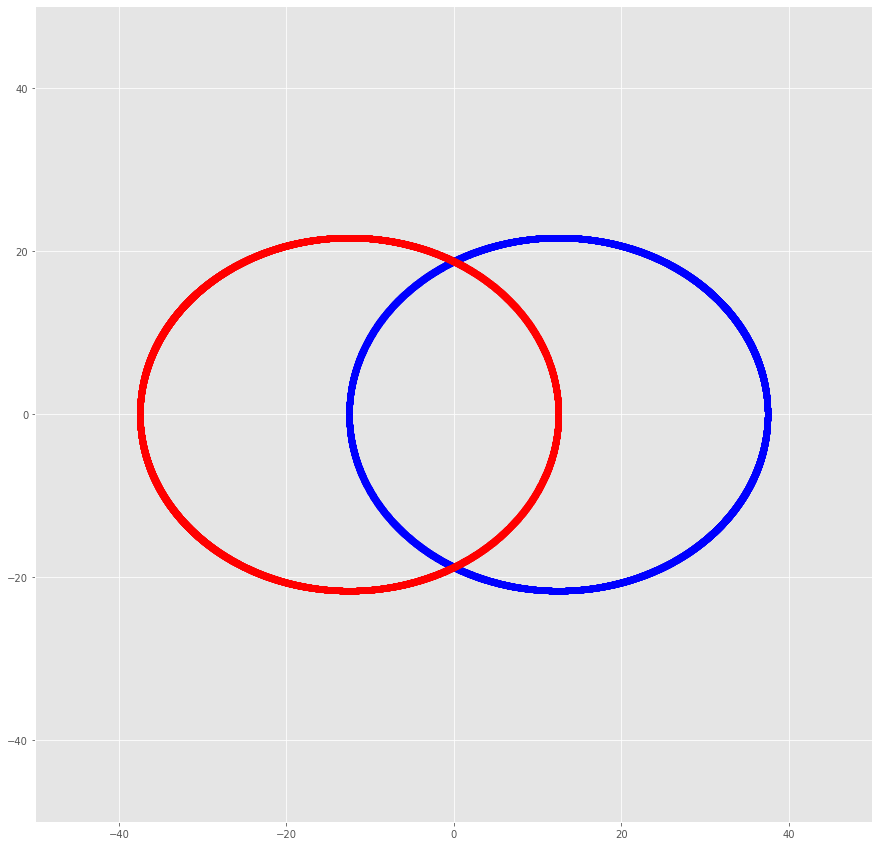

In [27]:
fig, ax = plt.subplots(figsize=(15,15))

ax.set_ylim(-50,50)
ax.set_xlim(-50,50)

ax.scatter(x1,y1,c='b')
ax.scatter(x2,y2,c='r')

